In [8]:
# install packages by pip3 install package_name
import itertools
import json
import pickle
import string
import numpy as np


from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [9]:
table = str.maketrans({key: None for key in string.punctuation})
english_stopwords = stopwords.words('english')
for n,stopword in enumerate(english_stopwords):
    english_stopwords[n] = stopword.translate(table).lower()
english_stopwords = set(english_stopwords)

def clean_tweet(tweet):
    # Split by white space
    words = tweet.split()
    # Remove anything with "@", "t.co","&"
    for n,word in enumerate(words):
        if "@" in word or "t.co" in word or "#" in word:# or "&" in word:
            words[n] = ""
        else:
            # Remove punctuation and lowercase
            words[n] = word.translate(table).lower()
            # Check if clean word in clean stopword set
            if words[n] in english_stopwords or not words[n].isalnum():
                words[n] = ""
            
    clean_tweet = " ".join(filter(None,words))
    return clean_tweet
    

In [14]:
dt_dir = "ECE219_tweet_data/"
filenames = ["tweets_#gopatriots.txt","tweets_#gohawks.txt"]

goPatriotsTweets = []
goHawksTweets = []
MASSACHUSETTS_FLAGS = ["Massachusetts","Rhode Island","Connecticut","New Hampshire","Maine","Vermont",
                       "MA","VT","NH","RI","CT","ME",
                       "Worcester","Providence","Springfield","New Haven","Hartford","Stamford","Boston"]
WASHINGTON_FLAGS = ["Washington","Seattle","WA"]

visitedTweets = set() # set to prevent repeat tweets 

for file in filenames:
    with open(dt_dir+file) as f:
        for line in f:
            json_tweet = json.loads(line)
            time = json_tweet['citation_date']
            text = json_tweet['tweet']['text']
            
            location = json_tweet['tweet']['user']['location']
            #location = json_tweet['location']
            MA_FLAG = False
            WA_FLAG = False
            for m in MASSACHUSETTS_FLAGS:
                if m in location:
                    MA_FLAG = True
        
            for w in WASHINGTON_FLAGS:
                if w in location:
                    WA_FLAG = True    
            
            cleanTweet = clean_tweet(text)
            if cleanTweet not in visitedTweets:
                visitedTweets.add(cleanTweet)
                sentiment_polarity = TextBlob(cleanTweet).sentiment.polarity
                sentiment_subjectivity = TextBlob(cleanTweet).sentiment.subjectivity
                if file == "tweets_#gopatriots.txt":
                    if MA_FLAG: 
                        goPatriotsTweets.append((text,time,sentiment_polarity,sentiment_subjectivity,"MA"))
                    if WA_FLAG:
                        goPatriotsTweets.append((text,time,sentiment_polarity,sentiment_subjectivity,"WA"))
                else:
                    if MA_FLAG:
                        goHawksTweets.append((text,time,sentiment_polarity,sentiment_subjectivity,"MA"))
                    if WA_FLAG:
                        goHawksTweets.append((text,time,sentiment_polarity,sentiment_subjectivity,"WA"))
                    
print("Number of #goPatriots tweets: %d" % len(goPatriotsTweets))
print("Number of #goHawks tweets: %d" % len(goHawksTweets))
                

Number of #goPatriots tweets: 1270
Number of #goHawks tweets: 39308


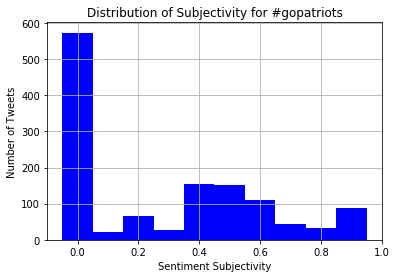

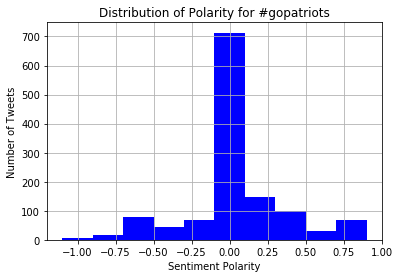

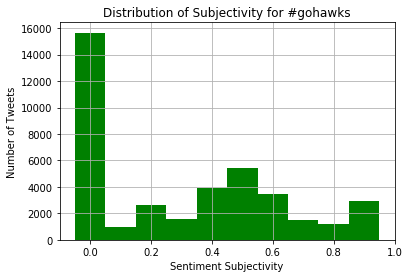

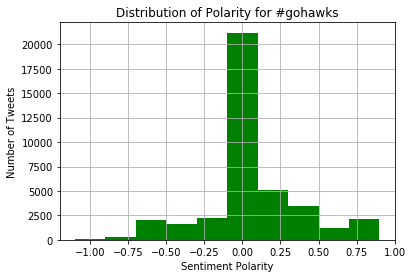

In [21]:
patriots_df = pd.DataFrame.from_records(goPatriotsTweets,columns=['text','citation_date_raw','sentiment_polarity','sentiment_subjectivity','location'])
patriots_df['sentiment_subjectivity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #gopatriots")
plt.show()

patriots_df['sentiment_polarity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #gopatriots")
plt.show()

hawks_df = pd.DataFrame.from_records(goHawksTweets,columns=['text','citation_date_raw','sentiment_polarity','sentiment_subjectivity','location'])
hawks_df['sentiment_subjectivity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #gohawks")
plt.show()

hawks_df['sentiment_polarity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #gohawks")
plt.show()

I think the takeaway from here could be, although the number of tweets are uneven, but the distributions are very similar. Therefore, we should be able to use these two samples comparatively.

In [22]:
Patriots_MA_df = patriots_df[patriots_df['location'] == "MA"]
Patriots_WA_df = patriots_df[patriots_df['location'] == "WA"]
Hawks_MA_df = hawks_df[hawks_df['location'] == "MA"]
Hawks_WA_df = hawks_df[hawks_df['location'] == "WA"]

print("Number of #goPatriots tweets in New England: %d" % len(Patriots_MA_df))
print("Number of #goPatriots tweets in Washington: %d" % len(Patriots_WA_df))
print("Number of #goHawks tweets in New England: %d" % len(Hawks_MA_df))
print("Number of #goHawks tweets in Washington: %d" % len(Hawks_WA_df))

Number of #goPatriots tweets in New England: 1178
Number of #goPatriots tweets in Washington: 92
Number of #goHawks tweets in New England: 830
Number of #goHawks tweets in Washington: 38478


From the above results, we can see that, Patriots is a team based on New England. Therefore, most tweets with location in New England areas are fans of Patriots. Fans of the other teams are in minority. Hawks is similar: most tweets with location in Washington are fans of Hawks with a minority of them are fans of Patriots.
7.2% and 2.1% respectively

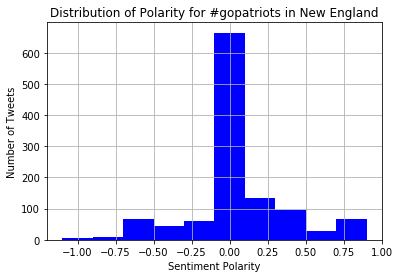

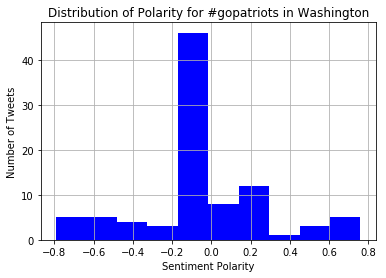

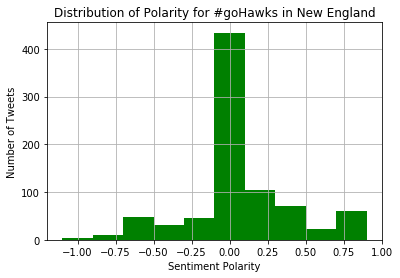

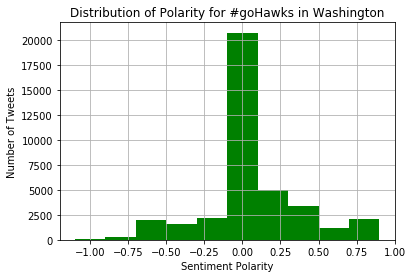

In [28]:
Patriots_MA_df['sentiment_polarity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #gopatriots in New England")
plt.show()

Patriots_WA_df['sentiment_polarity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #gopatriots in Washington")
plt.show()

Hawks_MA_df['sentiment_polarity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #goHawks in New England" )
plt.show()

Hawks_WA_df['sentiment_polarity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Polarity for #goHawks in Washington")
plt.show()


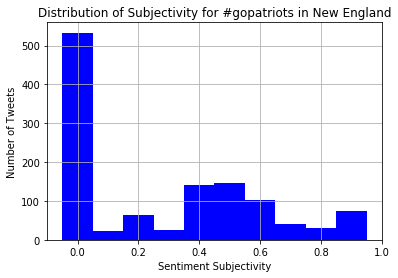

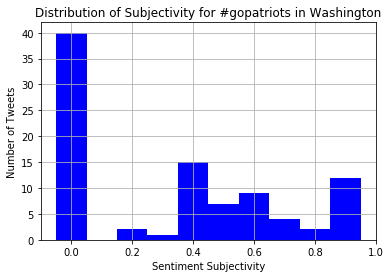

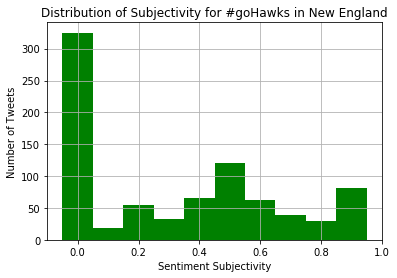

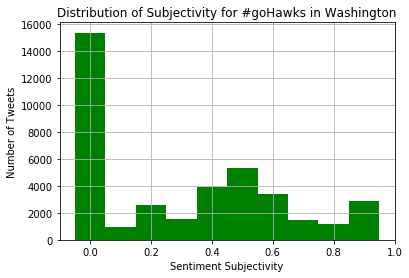

In [29]:
Patriots_MA_df['sentiment_subjectivity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #gopatriots in New England")
plt.show()

Patriots_WA_df['sentiment_subjectivity'].hist(color="Blue",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #gopatriots in Washington")
plt.show()

Hawks_MA_df['sentiment_subjectivity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #goHawks in New England")
plt.show()

Hawks_WA_df['sentiment_subjectivity'].hist(color="Green",align="left")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Subjectivity for #goHawks in Washington")
plt.show()

# Regression Analysis

In [38]:
# explain polarity by team and hours and locations and interactive effect
import statsmodels.api as sm
import numpy as np
import pandas as pd

# my df: patriots_df, patriots_df
patriots_df['patriots_dummy'] = 1
patriots_df['hawks_dummy'] = 0
hawks_df['patriots_dummy'] = 0
hawks_df['hawks_dummy'] = 1
dummy1 = pd.get_dummies(patriots_df['location'])
dummy2 = pd.get_dummies(hawks_df['location'])
patriots_df1 = pd.concat([patriots_df,dummy1],axis=1)
hawks_df1 = pd.concat([hawks_df,dummy2],axis=1)

tweet_df = patriots_df1.append(hawks_df1)
print(len(tweet_df))
tweet_df.head()

40578


,text,citation_date_raw,sentiment_polarity,sentiment_subjectivity,location,patriots_dummy,hawks_dummy,MA,WA
0,LeGarrette Blount does the Ray Lewis Dance #Th...,1421257541,-0.3,0.4,MA,1,0,1,0
1,@christinaballin thanks for the follow! \n#GoP...,1421241439,0.2,0.2,MA,1,0,1,0
2,@honeychocolate9 You too!! Only 4 more days un...,1421248980,0.0,0.0,MA,1,0,1,0
3,@HzmtH1 @WGRZ @jgermano1 next time he comes to...,1421259068,0.0,0.0,MA,1,0,1,0
4,@NESportsFan1106 thank you for the follow back...,1421261228,0.0,0.0,MA,1,0,1,0


In [47]:
X = tweet_df[['patriots_dummy',"WA"]]
y = tweet_df['sentiment_polarity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     sentiment_polarity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.831
Date:                Wed, 20 Mar 2019   Prob (F-statistic):             0.0217
Time:                        14:42:28   Log-Likelihood:                -10517.
No. Observations:               40578   AIC:                         2.104e+04
Df Residuals:                   40575   BIC:                         2.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1309      0.010     12.628      0.000       0.111       0.151
patriots_dummy    -0.0297      0.013     -2.276      0.023      -0.055      -0.004
WA                -0.0060      0.010     -0.577      0.564      -0.027       0.014
==============================================================================
Omnibus:                     1936.393   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2694.871
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       3.867   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
X = tweet_df[['patriots_dummy',"WA"]]
y = tweet_df['sentiment_subjectivity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     sentiment_subjectivity   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     3.967
Date:                    Wed, 20 Mar 2019   Prob (F-statistic):             0.0189
Time:                            14:42:45   Log-Likelihood:                -12167.
No. Observations:                   40578   AIC:                         2.434e+04
Df Residuals:                       40575   BIC:                         2.437e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3468      0.011     32.126      0.000       0.326       0.368
patriots_dummy    -0.0346      0.014     -2.552      0.011      -0.061      -0.008
WA                -0.0113      0.011     -1.039      0.299      -0.033       0.010
==============================================================================
Omnibus:                    15014.698   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3241.962
Skew:                           0.440   Prob(JB):                         0.00
Kurtosis:                       1.931   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# Add the time variable
def parse_date_pst(df):
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    df['citation_date'] = pd.to_datetime(df['citation_date_raw'], unit='s')
    df['citation_date_pst'] = pd.to_datetime(df['citation_date_raw'], unit='s').apply(lambda x: x.tz_localize(utc_tz).astimezone(pst_tz))
    df['date'] = df['citation_date_pst'].apply(lambda x: x.strftime('%Y%m%d'))
    df['hour'] = df['citation_date_pst'].apply(lambda x: x.hour)
    df['minute'] = df['citation_date_pst'].apply(lambda x: x.minute)

In [122]:
# Average the sentiment by hours
parse_date_pst(Patriots_MA_df)
Patriots_MA_df1 = Patriots_MA_df.groupby([Patriots_MA_df['date']]).mean()
Patriots_MA_polarity = np.array(Patriots_MA_df1['sentiment_polarity'])
Patriots_MA_s = np.array(Patriots_MA_df1['sentiment_subjectivity'])

parse_date_pst(Patriots_WA_df)
Patriots_WA_df1 = Patriots_WA_df.groupby([Patriots_WA_df['date']]).mean()
Patriots_WA_polarity = np.array(Patriots_WA_df1['sentiment_polarity'])
Patriots_WA_s = np.array(Patriots_WA_df1['sentiment_subjectivity'])

parse_date_pst(Hawks_MA_df)
Hawks_MA_df1 = Hawks_MA_df.groupby([Hawks_MA_df['date']]).mean()
Hawks_MA_polarity = np.array(Hawks_MA_df1['sentiment_polarity'])
Hawks_MA_s = np.array(Hawks_MA_df1['sentiment_subjectivity'])

parse_date_pst(Hawks_WA_df)
Hawks_WA_df1 = Hawks_WA_df.groupby([Hawks_WA_df['date']]).mean()
Hawks_WA_polarity = np.array(Hawks_WA_df1['sentiment_polarity'])
Hawks_WA_s = np.array(Hawks_WA_df1['sentiment_subjectivity'])

print(Patriots_MA_df1.head(30))
print(Patriots_WA_df1.head(30))
print(Hawks_MA_df1.head(30))
print(Hawks_WA_df1.head(30))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

          citation_date_raw  sentiment_polarity  sentiment_subjectivity  \
date                                                                      
20150114       1.421254e+09           -0.020000                0.120000   
20150115       1.421355e+09            0.178125                0.271875   
20150116       1.421443e+09            0.054924                0.240720   
20150117       1.421535e+09            0.067857                0.208730   
20150118       1.421624e+09            0.097642                0.314970   
20150119       1.421697e+09            0.215225                0.326426   
20150120       1.421789e+09            0.030754                0.268254   
20150121       1.421866e+09            0.219792                0.358333   
20150122       1.421962e+09            0.070431                0.331795   
20150123       1.422049e+09            0.294860                0.399970   
20150124       1.422138e+09            0.198457                0.387191   
20150125       1.422219e+

In [126]:
# build the dataset manually
agg_tweet = pd.DataFrame({'date':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 
                          'PMP': [-0.02,  0.18  ,  0.05,  0.07,  0.09764227,
        0.21522517,  0.03075397,  0.21979167,  0.07043135,  0.29486037,
        0.19845679,  0.21598485,  0.36725146,  0.15315356,  0.16904762,
        0.11666667,  0.11957071,  0.28333333,  0.08003122,  0.12838542, 0,0.075,0,0,0],
                          'PWP':[0,0,0.28333333, -0.275     ,  0.15960859, -0.08333333,  0.13333333,
        0,0,0        ,  0.24791667,  0        ,  0  ,0,0,0,0,0      , -0.01861893,0,0,0,-0.5,0,0   ], 
                          'HMP': [0.2602381 ,  0.10979798,  0.12305195,  0.12980372,  0.10105698,
        0.21579423,  0.11111111,  0.11944444,  0.26164773,  0.02838542,
        0.21691468,  0.09009663, -0.0322314 ,  0.19544631,  0.10430038,
        0.25      ,  0.29327201,  0.33333333,  0.13205822,  0.05958661,0,0,0,0,0], 
                          'HWP': [0.14,  0.16,  0.15776615,  0.11790666,  0.09027323,
        0.1396185 ,  0.15938753,  0.18,  0.16,  0.18109378,
        0.15944311,  0.20591802,  0.16,  0.15460133,  0.1512375 ,
        0.12996491,  0.16428146,  0.16,  0.11529406,  0.13919045,
        0.05691795,  0.05917319, -0.02,  0.13695166, -0.2     ],
                          'PMS': [0.12 , 0.271875  , 0.2407197 , 0.20873016, 0.31496984,
       0.32642572, 0.26825397, 0.35833333, 0.33179499, 0.39997029,
       0.38719136, 0.45264791, 0.34459064, 0.18431037, 0.32226891,
       0.13, 0.34, 0.38333333, 0.29893734, 0.28907986,0,
       0.37,0,0,0],
                          'PWS':[0,0,0.41666667, 0.5       , 0.43239899, 0.43333333, 0.21666667,
       0,0,0        , 0.42604167, 0.07692308, 0,0,0,0,0,0 , 0.33530904,0,0,0,
       1,0,0], 
                          'HMS': [0.3577381 , 0.35929293, 0.31623377, 0.45757576, 0.35523594,
       0.37147706, 0.39722222, 0.23333333, 0.29924242, 0.34088542,
       0.43844246, 0.36802712, 0.35013774, 0.33038263, 0.43467478,
       0.3       , 0.45218254, 0.33333333, 0.33100845, 0.40310,0,0,0,0,0], 
                          'HWS': [0.31, 0.33, 0.32, 0.33, 0.34,
       0.38, 0.35, 0.37, 0.3645182 , 0.36205969,
       0.32, 0.34, 0.34, 0.33089992, 0.32631588,
       0.29, 0.30, 0.33214592, 0.32069765, 0.38083607,
       0.30, 0.28, 0.35080409, 0.33386003, 0.7]})

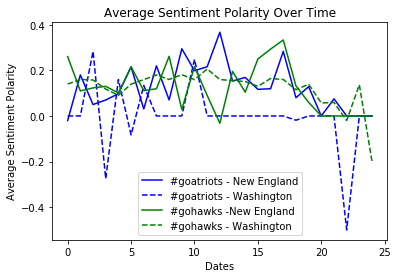

In [129]:
plt.plot(agg_tweet['PMP'],'b')
plt.plot(agg_tweet['PWP'],color="blue",ls="--")
plt.plot(agg_tweet['HMP'],color="g")
plt.plot(agg_tweet['HWP'],color="green",ls="--")
plt.xlabel("Dates")
plt.ylabel("Average Sentiment Polarity")
plt.legend(['#goatriots - New England','#goatriots - Washington','#gohawks - New England','#gohawks - Washington'])
plt.title("Average Sentiment Polarity Over Time")
plt.show()

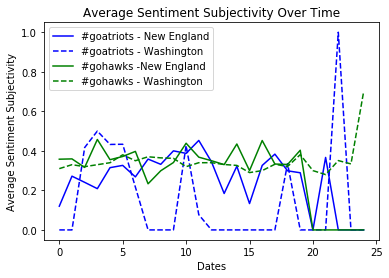

In [130]:
plt.plot(agg_tweet['PMS'],'b')
plt.plot(agg_tweet['PWS'],color="blue",ls="--")
plt.plot(agg_tweet['HMS'],color="g")
plt.plot(agg_tweet['HWS'],color="green",ls="--")
plt.xlabel("Dates")
plt.ylabel("Average Sentiment Subjectivity")
plt.legend(['#goatriots - New England','#goatriots - Washington','#gohawks - New England','#gohawks - Washington'])
plt.title("Average Sentiment Subjectivity Over Time")
plt.show()
plt.show()